<a href="https://colab.research.google.com/github/Geoffysicist/skewt/blob/main/f160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybufrkit
!pip install metpy

     |████████████████████████████████| 361 kB 4.2 MB/s 
     |████████████████████████████████| 6.3 MB 36.5 MB/s 
     |████████████████████████████████| 209 kB 39.0 MB/s 


In [ ]:
# Decode a BUFR file
from pybufrkit.decoder import Decoder
from pybufrkit.dataquery import NodePathParser, DataQuerent
# decoder = Decoder()
with open('/content/soundings/bufr309052_all_20211209_0005_8.bfr', 'rb') as in_bufr:
    bufr_message = Decoder().process(in_bufr.read())

# bufr_message

In [ ]:
# Query the data
# from pybufrkit.dataquery import NodePathParser, DataQuerent
pressures = DataQuerent(NodePathParser()).query(bufr_message, '303054/007004')
temperatures = DataQuerent(NodePathParser()).query(bufr_message, '303054/012101')
dewpoints = DataQuerent(NodePathParser()).query(bufr_message, '303054/012103')
wind_dir = DataQuerent(NodePathParser()).query(bufr_message, '303054/011001')
wind_speed = DataQuerent(NodePathParser()).query(bufr_message, '303054/011002')
geo_pot_height = DataQuerent(NodePathParser()).query(bufr_message, '303054/010009')

all_data = {
  'Pressure': pressures, 
  'Temperature': temperatures, 
  'Dewpoint': dewpoints, 
  'Wind Dir': wind_dir, 
  'Wind Speed': wind_speed, 
  'GPH': geo_pot_height
  }

In [ ]:
# check all lists are the same size and change to lists
from pybufrkit.renderer import FlatJsonRenderer
for key, data in all_data.items():
  d = FlatJsonRenderer().render(data)
  print(f'{key}: {len(d[0])}')
  all_data[key] = d[0]


Pressure: 2650
Temperature: 2650
Dewpoint: 2650
Wind Dir: 2650
Wind Speed: 2650
GPH: 2650


In [ ]:
# clean all the data for missing values
for key, data in all_data.items():
  for i, val in enumerate(data):
    if val is None:
      for k, d in all_data.items():
        d.pop(i)
        print(f'{k}: {len(d)}')




In [ ]:
for key, data in all_data.items():
  for i, val in enumerate(data):
    if i < 5: print(f'{key},{i}: {val}')

Pressure,0: 100060.0
Pressure,1: 100000.0
Pressure,2: 99930.0
Pressure,3: 99710.0
Pressure,4: 99570.0
Temperature,0: 294.13
Temperature,1: 293.76
Temperature,2: 293.36
Temperature,3: 293.15
Temperature,4: 293.15
Dewpoint,0: 288.94
Dewpoint,1: 289.01
Dewpoint,2: 289.07
Dewpoint,3: 288.79
Dewpoint,4: 288.79
Wind Dir,0: 171
Wind Dir,1: 174
Wind Dir,2: 174
Wind Dir,3: 175
Wind Dir,4: 175
Wind Speed,0: 1.1
Wind Speed,1: 1.2
Wind Speed,2: 1.2
Wind Speed,3: 1.2
Wind Speed,4: 1.2
GPH,0: 76
GPH,1: 80
GPH,2: 84
GPH,3: 102
GPH,4: 117


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

In [ ]:
# Check that pressure decreases monotonically, if not clean it
last_val = 0
ctr = 0
for i, val in enumerate(all_data['Pressure']):
  if last_val:
    if val >= last_val:
      for d in all_data.values():
        d.pop(i)
      print(f'{i}: {val} >= {i-1}: {last_val}')
      ctr += 1
  last_val = val

ctr

0

In [ ]:
p = all_data['Pressure']*units.Pa
T = all_data['Temperature']*units.kelvin
Td = all_data['Dewpoint']*units.kelvin
wind_speed = all_data['Wind Speed']*units('m/s')
wind_dir  = all_data['Wind Dir']*units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)


In [ ]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

92662.01660551074 pascal 287.74530833644707 kelvin


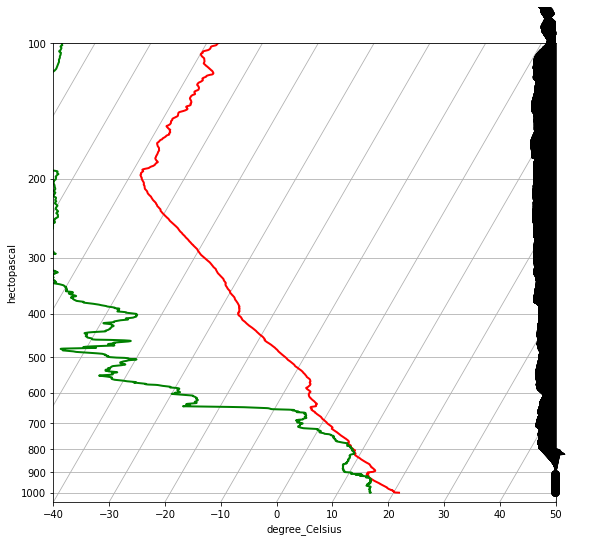

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.show()

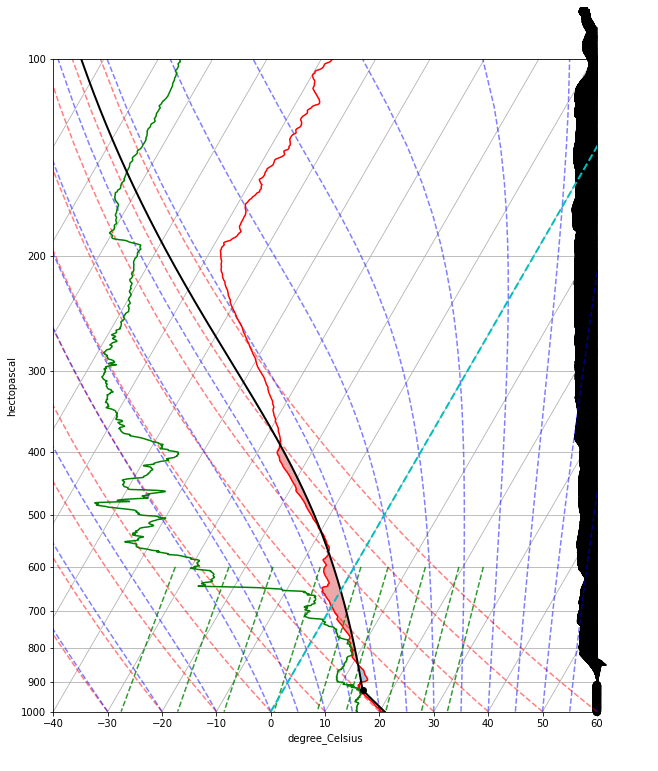

In [ ]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(12, 12))
skew = SkewT(fig, rotation=30, aspect=120)


# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof, Td)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()